In [59]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
torch.manual_seed(0)

In [2]:
import zipfile

zip_file_path = '/content/drive/MyDrive/maps.zip'
extracted_folder_path = '/content/Maps'  # Change to your desired extraction path

# Create the target directory if it doesn't exist.
import os
os.makedirs(extracted_folder_path, exist_ok=True)

# Unzip the file.
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [69]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock:
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [70]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net -
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock:
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [5]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

In [60]:
def norm_relu_layer(out_channel, do_norm, norm, relu):
    if do_norm:
        if norm == 'instance':
            norm_layer = nn.InstanceNorm2d(out_channel)
        elif norm == 'batch':
            norm_layer = nn.BatchNorm2d(out_channel)
        else:
            raise NotImplementedError("norm error")
    else:
        norm_layer = nn.Dropout2d(0)  # Identity

    if relu is None:
        relu_layer = nn.ReLU()
    else:
        relu_layer = nn.LeakyReLU(relu, inplace=True)

    return norm_layer, relu_layer

In [61]:
def Conv_Norm_ReLU(in_channel, out_channel, kernel, padding=0, dilation=1, groups=1, stride=1, bias=True,
                   do_norm=True, norm='batch', relu=None):
    """
    Convolutional -- Norm -- ReLU Unit
    :param norm: 'batchnorm' --> use BatchNorm2D, 'instancenorm' --> use InstanceNorm2D, 'none' --> Identity()
    :param relu: None -> Use vanilla ReLU; float --> Use LeakyReLU(relu)

    :input (N x in_channel x H x W)
    :return size same as nn.Conv2D
    """
    norm_layer, relu_layer = norm_relu_layer(out_channel, do_norm, norm, relu)

    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, padding=padding, stride=stride,
                  dilation=dilation, groups=groups, bias=bias),
        norm_layer,
        relu_layer
    )


In [62]:
def Deconv_Norm_ReLU(in_channel, out_channel, kernel, padding=0, output_padding=0, stride=1, groups=1,
                     bias=True, dilation=1, do_norm=True, norm='batch'):
    """
    Deconvolutional -- Norm -- ReLU Unit
    :param norm: 'batchnorm' --> use BatchNorm2D, 'instancenorm' --> use InstanceNorm2D, 'none' --> Identity()
    :param relu: None -> Use vanilla ReLU; float --> Use LeakyReLU(relu)

    :input (N x in_channel x H x W)
    :return size same as nn.ConvTranspose2D
    """
    norm_layer, relu_layer = norm_relu_layer(out_channel, do_norm, norm, relu=None)
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel, out_channel, kernel, padding=padding, output_padding=output_padding,
                           stride=stride, groups=groups, bias=bias, dilation=dilation),
        norm_layer,
        relu_layer
    )

In [63]:
class ResidualLayer(nn.Module):
    """
    Residual block used in Johnson's network model:
    Our residual blocks each contain two 3×3 convolutional layers with the same number of filters on both
    layer. We use the residual block design of Gross and Wilber [2] (shown in Figure 1), which differs from
    that of He et al [3] in that the ReLU nonlinearity following the addition is removed; this modified design
    was found in [2] to perform slightly better for image classification.
    """

    def __init__(self, channels, kernel_size, final_relu=False, bias=False, do_norm=True, norm='batch'):
        super().__init__()
        self.kernel_size = kernel_size
        self.channels = channels
        self.padding = (self.kernel_size[0] - 1) // 2
        self.final_relu = final_relu

        norm_layer, relu_layer = norm_relu_layer(self.channels, do_norm, norm, relu=None)
        self.layers = nn.Sequential(
            nn.Conv2d(self.channels, self.channels, self.kernel_size, padding=self.padding, bias=bias),
            norm_layer,
            nn.ReLU(),
            nn.Conv2d(self.channels, self.channels, self.kernel_size, padding=self.padding, bias=bias),
            norm_layer
        )

    def forward(self, input):
        # input (N x channels x H x W)
        # output (N x channels x H x W)
        out = self.layers(input)
        if self.final_relu:
            return nn.ReLU(out + input)
        else:
            return out + input

In [71]:
class ResNet6(nn.Module):
    """
    The Generator architecture in < Perceptual Losses for Real-Time Style Transfer and Super-Resolution >
    by Justin Johnson, et al.
    """

    def __init__(self, in_channels=3, out_channels=3, do_norm=True, norm='batch', bias=True):
        super(ResNet6, self).__init__()
        model = []
        model += [Conv_Norm_ReLU(in_channels, 32, (7, 7), padding=3, stride=1, bias=bias, do_norm=do_norm, norm=norm),
                  # c7s1-32
                  Conv_Norm_ReLU(32, 64, (3, 3), padding=1, stride=2, bias=bias, do_norm=do_norm, norm=norm),  # d64
                  Conv_Norm_ReLU(64, 128, (3, 3), padding=1, stride=2, bias=bias, do_norm=do_norm, norm=norm)]  # d128
        for i in range(6):
            model += [ResidualLayer(128, (3, 3), final_relu=False, bias=bias)]  # R128
        model += [
            Deconv_Norm_ReLU(128, 64, (3, 3), padding=1, output_padding=1, stride=2, bias=bias, do_norm=do_norm, norm=norm),
            # u64
            Deconv_Norm_ReLU(64, 32, (3, 3), padding=1, output_padding=1, stride=2, bias=bias, do_norm=do_norm, norm=norm),
            # u32
            nn.Conv2d(32, out_channels, (7, 7), padding=3, stride=1, bias=bias),  # c7s1-3
            nn.Tanh()]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        """
        :param input: (N x channels x H x W)
        :return: output: (N x channels x H x W) with numbers of range [-1, 1] (since we use tanh())
        """
        return self.model(input)

In [72]:
from torchsummary import summary
device = 'cuda'
model=ResNet6(3,3,True,'batch',True).to(device)

# Print the model summary
summary(model, (3, 256, 256))  # Adjust input size as needed

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

In [37]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake.
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [38]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs = 10
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256


In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

import torchvision
dataset = torchvision.datasets.ImageFolder("/content/Maps/Files/maps", transform=transform)

In [80]:
gen = ResNet6(3,3,True,'batch',True).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Can be changed to False if not using a pretrained model
pretrained = True
if pretrained:
    loaded_state = torch.load("/content/pix2pix_10800.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

In [41]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator
                  predictions and the true labels and returns a adversarial
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator
                    outputs and the real images and returns a reconstructuion
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    return gen_loss

In [74]:
def test_gen_reasonable(num_images=10):
    gen = torch.zeros_like
    disc = lambda x, y: torch.ones(len(x), 1)
    real = None
    condition = torch.ones(num_images, 3, 10, 10)
    adv_criterion = torch.mul
    recon_criterion = lambda x, y: torch.tensor(0)
    lambda_recon = 0
    assert get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon).sum() == num_images

    disc = lambda x, y: torch.zeros(len(x), 1)
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)).sum() == 0

    adv_criterion = lambda x, y: torch.tensor(0)
    recon_criterion = lambda x, y: torch.abs(x - y).max()
    real = torch.randn(num_images, 3, 10, 10)
    lambda_recon = 2
    gen = lambda x: real + 1
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 2) < 1e-4

    adv_criterion = lambda x, y: (x + y).max() + x.max()
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 3) < 1e-4
test_gen_reasonable()
print("Success!")

Success!


  0%|          | 0/549 [00:00<?, ?it/s]

Pretrained initial state


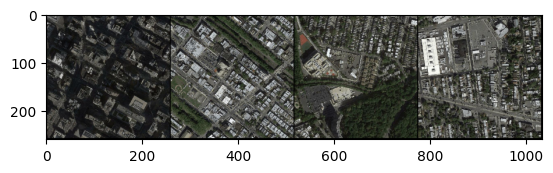

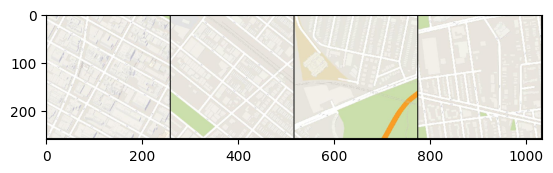

Epoch 0: Step 11000: Generator (ResNet6) loss: 9.847235968112939, Discriminator loss: 0.354377057775855


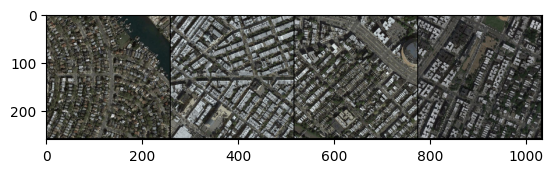

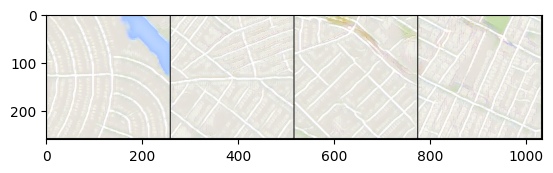

Epoch 0: Step 11200: Generator (ResNet6) loss: 9.453970320224764, Discriminator loss: 0.3426584060862661


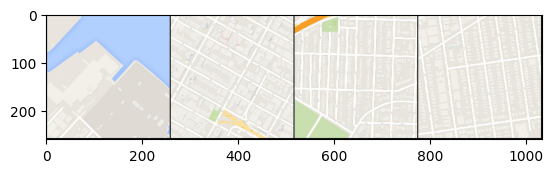

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: Step 11400: Generator (ResNet6) loss: 9.3280023431778, Discriminator loss: 0.3565588596835732


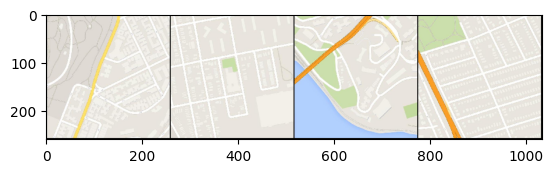

Epoch 1: Step 11600: Generator (ResNet6) loss: 9.996379053592685, Discriminator loss: 0.33278216101229185


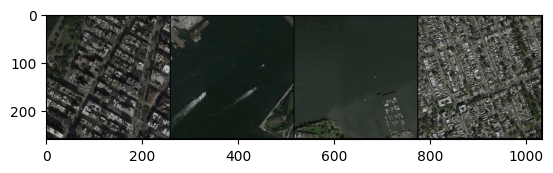

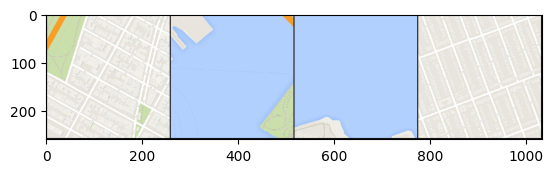

Epoch 1: Step 11800: Generator (ResNet6) loss: 9.84943299055099, Discriminator loss: 0.3247065575234591


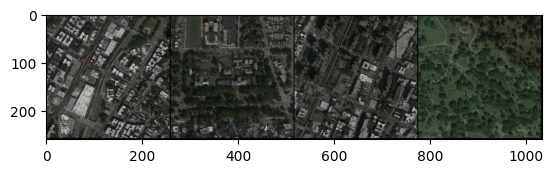

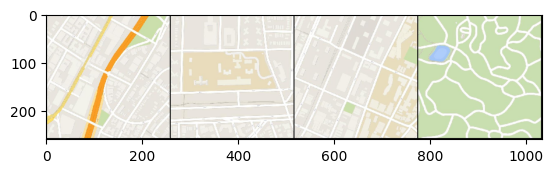

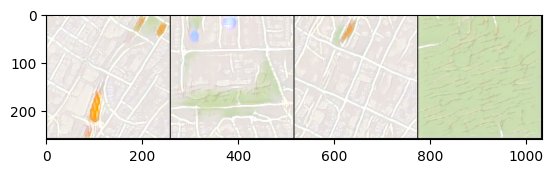

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: Step 12000: Generator (ResNet6) loss: 9.716239416599276, Discriminator loss: 0.3123782400041817


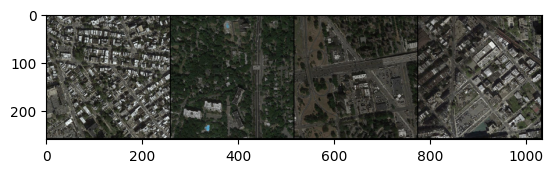

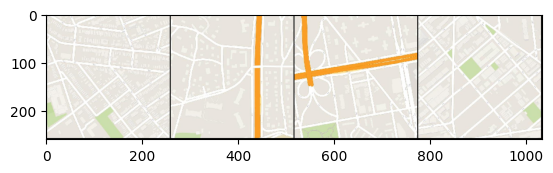

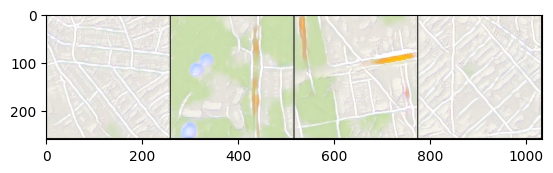

Epoch 2: Step 12200: Generator (ResNet6) loss: 10.087380738258364, Discriminator loss: 0.2737602485902607


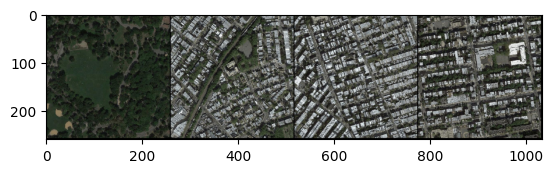

Epoch 2: Step 12400: Generator (ResNet6) loss: 9.494968318939208, Discriminator loss: 0.3573799739219247


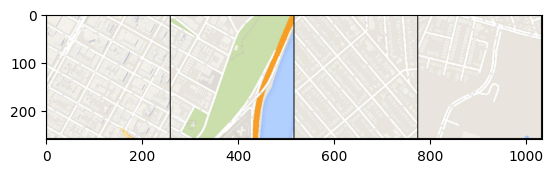

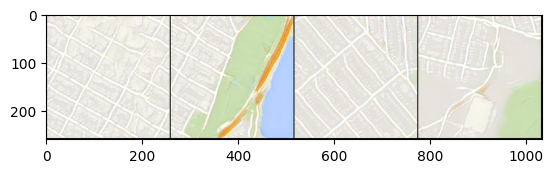

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: Step 12600: Generator (ResNet6) loss: 10.031906781196593, Discriminator loss: 0.2791832504607737


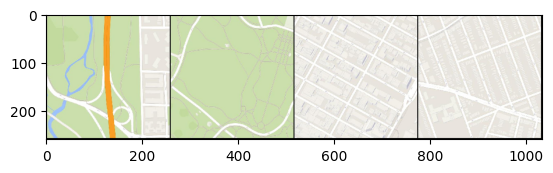

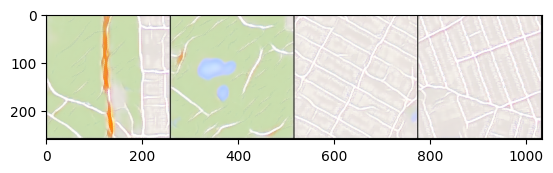

Epoch 3: Step 12800: Generator (ResNet6) loss: 9.77408572196961, Discriminator loss: 0.3569774923846124


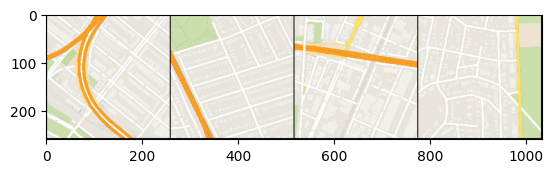

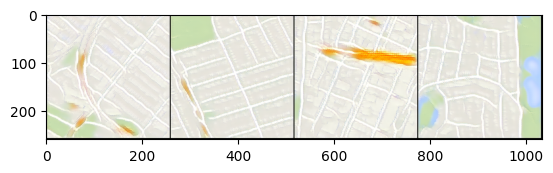

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: Step 13000: Generator (ResNet6) loss: 9.55826633930206, Discriminator loss: 0.3669811076670885


Epoch 4: Step 13200: Generator (ResNet6) loss: 10.285937025547028, Discriminator loss: 0.271160306315869


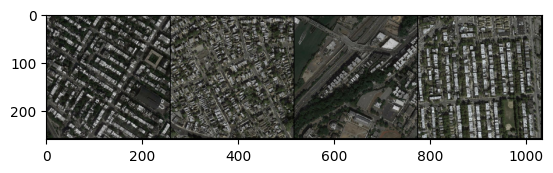

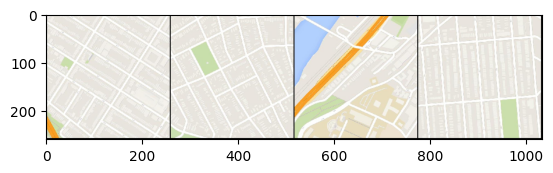

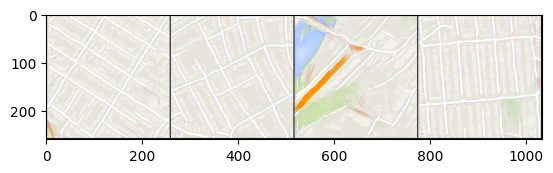

Epoch 4: Step 13400: Generator (ResNet6) loss: 9.850405335426327, Discriminator loss: 0.3163480784744026


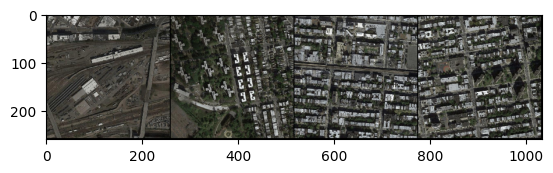

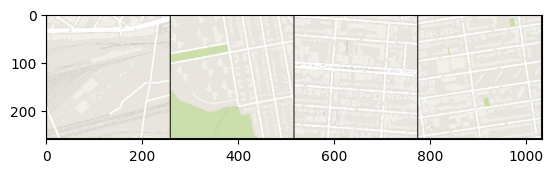

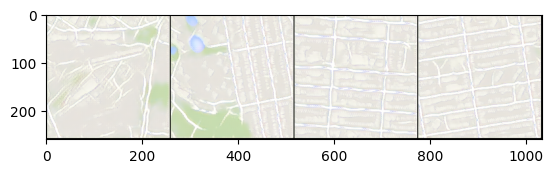

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 5: Step 13600: Generator (ResNet6) loss: 9.885161993503566, Discriminator loss: 0.28498417839407936


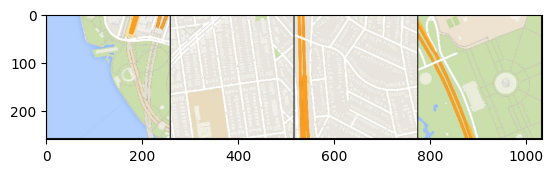

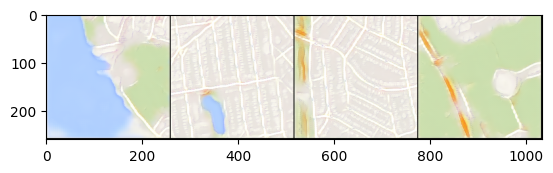

Epoch 5: Step 13800: Generator (ResNet6) loss: 9.64843156337738, Discriminator loss: 0.32053441116586345


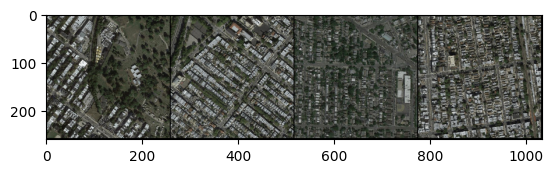

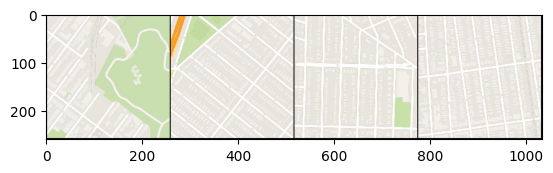

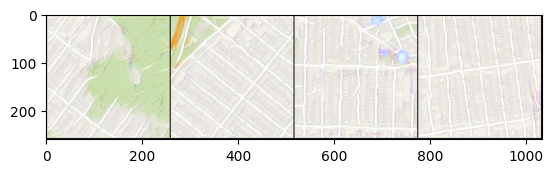

Epoch 5: Step 14000: Generator (ResNet6) loss: 9.921082849502561, Discriminator loss: 0.23434238550253222


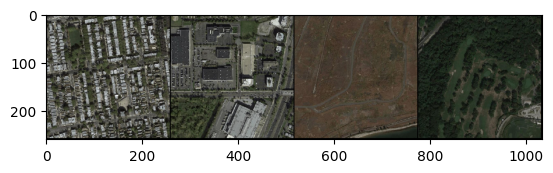

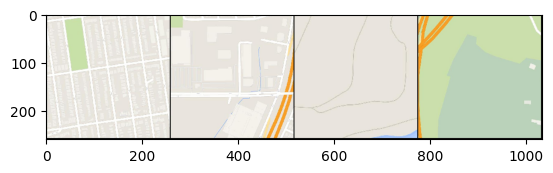

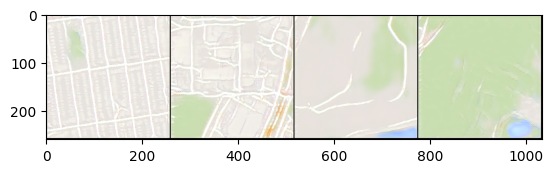

  0%|          | 0/549 [00:00<?, ?it/s]

In [ ]:
#from skimage import color
import numpy as np

def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)
            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step+10800}: Generator (ResNet6) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                #  save_model can be changed to True to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step+10800}.pth")
            cur_step += 1
train()